In [226]:
import torch #for building nn and manipulate tensors
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt # for making figures
import random #for shuffling values 
import torchmetrics #calculate evaluation metrics 
import pandas as pd
%matplotlib inline

In [227]:
#Read words in our VENEZUELAN dataset
names= open('corpus/name_list_vzl.txt', 'r', encoding='utf-8').read().lower().splitlines()
print(f'Number of names in dataset:{len(set(names))}')

Number of names in dataset:531


In [228]:
#Building vocabulary 
chars = sorted(list(set(''.join(names)))) 
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 #adds dot in position 0 for building block size 
itos = {i:s for s,i in stoi.items()} 
len_vocab= len(itos)
print(itos)
print(f'Lenght of vocabulary: {len_vocab}') 

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'á', 29: 'é', 30: 'í', 31: 'ó', 32: 'ú', 0: '.'}
Lenght of vocabulary: 33


In [229]:
# Build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], [] #X are the values, Y are the labels 
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(names) #shuffles names in dataset 


#Train/validation/test 
n1 = int(0.8*len(names)) 
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1]) #training split. 80%.
Xval, Yval = build_dataset(names[n1:n2]) #validation split. 10%. 
Xte, Yte = build_dataset(names[n2:]) #test split. 10%. 

torch.Size([3674, 3]) torch.Size([3674])
torch.Size([442, 3]) torch.Size([442])
torch.Size([491, 3]) torch.Size([491])


In [230]:
#Shape of training, validation  and test set 
print('Training set:',Xtr.shape, Xtr.dtype)
print('Validation set:', Xval.shape, Yval.shape)
print('Test set:', Xte.shape, Yte.shape)

Training set: torch.Size([3674, 3]) torch.int64
Validation set: torch.Size([442, 3]) torch.Size([442])
Test set: torch.Size([491, 3]) torch.Size([491])


In [231]:
#Setting number of neurons and batch size

#Number of neurons
neurons= 300

#Batch size 
batch_size= 60

In [232]:
#Building of NN 
g = torch.Generator().manual_seed(2147483647) # for reproducibility
dim_embedding = 33 #dimensions of embedding 

C = torch.randn((len_vocab, dim_embedding), generator=g) #Look-up table C 

In [233]:
#Initializes weights

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

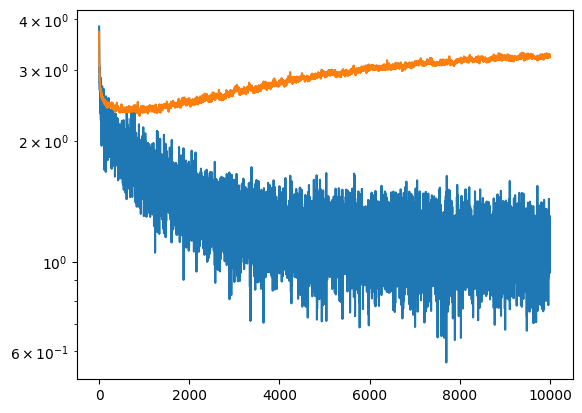

In [234]:
#Defines model 

model = nn.Sequential(nn.Linear(block_size*dim_embedding, neurons), nn.Tanh(), nn.Linear(neurons, len_vocab))
model.apply(weights_init)

#Loss function and learning rate
optimizer = optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

lossi= [] #stores loss values per iteration
lossval=[] #stores loss of validation values per iteration 

for i in range(10000):   #Trains NN and looks for optimal number of iteration 
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]].view(-1, block_size*dim_embedding) 

  logits = model(emb)

  optimizer.zero_grad()
  loss = criterion(logits, Ytr[ix])
  loss.backward()
  optimizer.step()

  # track stats
  lossi.append(loss.item())

  emb_val = C[Xval].view(-1, block_size*dim_embedding)

  logits = model(emb_val)
  loss_val = criterion(logits, Yval)
  lossval.append(loss_val.item())

plt.semilogy(lossi)
plt.semilogy(lossval)
plt.show()
iters_opt = torch.argmin(torch.tensor(lossval))

In [235]:
#Optimal iterations
iters_opt = torch.argmin(torch.tensor(lossval))
iters_opt

tensor(900)

In [236]:
#NN with optimized number of iterations 

model.apply(weights_init) #redefines weights of model

for i in range(iters_opt):
  
 # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]].view(-1, block_size*dim_embedding) # (32, 3, 10)

  logits = model(emb)

  optimizer.zero_grad()
  loss = criterion(logits, Ytr[ix])
  loss.backward()
  optimizer.step()

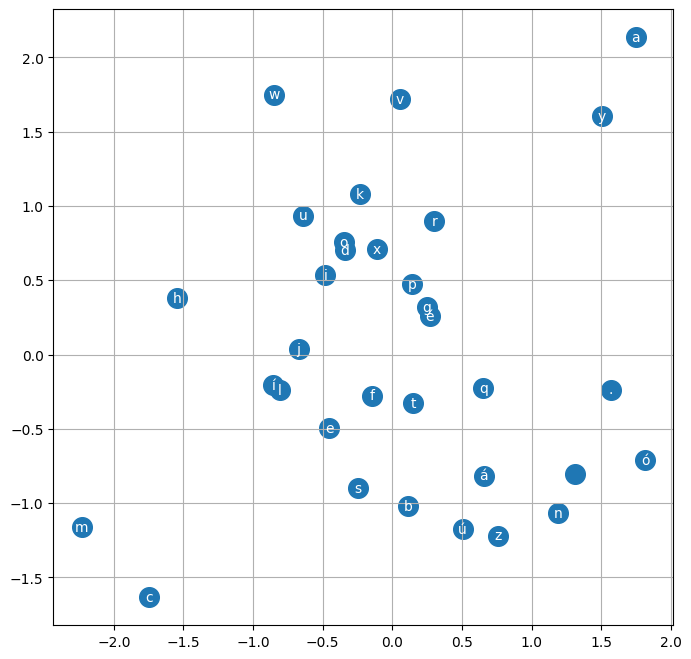

In [237]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [238]:
#Testing 
emb_tes = C[Xte].view(-1, block_size*dim_embedding) 

logits = model(emb_tes)

#Cross-entropy 
loss = F.cross_entropy(logits, Yte)
print(f'Loss of our dataset:{loss.item()}')

#Perplexity 
# Reshape logits to add a dummy dimension for seq_len
logits = logits.unsqueeze(1)  
print('Squeezed shape:', logits.shape)
# Calculate perplexity
perplexity = torch.exp(loss)
print(f"Perplexity: {perplexity.item()}")

Loss of our dataset:2.106743574142456
Squeezed shape: torch.Size([491, 1, 33])
Perplexity: 8.22142505645752


In [239]:
# sample from the model
g = torch.Generator().manual_seed(2147048347 + 10)
generated_names_list=[]
for _ in range(200):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])].view(1, block_size*dim_embedding) # (1,block_size,d)
      logits = model(emb)
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    generated_names= ''.join(itos[i] for i in out)
    generated_names_list.append(generated_names)
    print(generated_names)


maruona mbris fargeman.
mablla.
nore.
fed.
fevroe.
nora.
roudy.
osa.
mani.
mayvintoioangeeliam.
maría der.
mayrela.
feina.
eulyany.
hesto.
ilianiegsoimi.
celes.
sabriela.
nelzmira.
maría hel.
bica.
norina.
gro.
fayn.
valguetanriques.
jhou.
jes.
ven.
min.
aluel.
yedio molina.
puina.
lunno.
nuly mori.
ohannié.
mares.
may.
zula.
eudya.
janka.
maría daniel.
audy.
oxa.
andey.
wohnimófeen.
wanlinia.
walla.
ywo.
sved.
solangerina.
mariy.
cisa.
lucine.
edo.
janmer.
manía.
angelons.
josé unca.
oscino.
buliana.
carla.
josé gely.
opanter.
marian.
angel.
sanyel.
fadra.
maryan.
ena.
wavmo.
juan morel.
jetú.
nepóneé.
dora.
ana.
wnulyn.
jorngio.
onima.
sha.
clorea.
nois carmon.
naul.
marían.
rosniicanlicia.
jonpirlokima.
alo.
luangel.
marix.
josdo.
setza.
moria.
dan.
yoxyn.
jusí fernandrian.
naun.
marel.
nofmanuer.
euma.
angelyn.
oris.
mir.
luss favixan.
maría mer.
arey.
caxmaría de hel.
aerióngezka.
deo.
mariquií mary.
desdy.
luida.
juan joyd.
noid.
shay.
pfdres.
luzsobeita.
des.
rsumí.
betriomoi.
n

In [240]:
#Cleans unwanted characters (i.e. '.')
def output_cleaning(list_of_names):
    final= []
    for i in list_of_names:
        if i.endswith('.'): 
            name_only= i[:-1]  # deletes final '.'
            final.append(name_only)
        else:
            final.append(i)  # appends original name 
    return final

In [241]:
#Original names only 
generated_names_list= output_cleaning(generated_names_list)
original_names= [n for n in generated_names_list if n not in names]
print(f'Number of original names:{len(original_names)}')
print(original_names)

Number of original names:192
['maruona mbris fargeman', 'mablla', 'nore', 'fed', 'fevroe', 'nora', 'roudy', 'osa', 'mani', 'mayvintoioangeeliam', 'maría der', 'mayrela', 'feina', 'eulyany', 'hesto', 'ilianiegsoimi', 'celes', 'sabriela', 'nelzmira', 'maría hel', 'bica', 'norina', 'gro', 'fayn', 'valguetanriques', 'jhou', 'jes', 'ven', 'min', 'aluel', 'yedio molina', 'puina', 'lunno', 'nuly mori', 'ohannié', 'mares', 'may', 'zula', 'eudya', 'janka', 'maría daniel', 'audy', 'oxa', 'andey', 'wohnimófeen', 'wanlinia', 'walla', 'ywo', 'sved', 'solangerina', 'mariy', 'cisa', 'lucine', 'edo', 'janmer', 'manía', 'angelons', 'josé unca', 'oscino', 'buliana', 'josé gely', 'opanter', 'angel', 'sanyel', 'fadra', 'maryan', 'ena', 'wavmo', 'juan morel', 'jetú', 'nepóneé', 'wnulyn', 'jorngio', 'onima', 'sha', 'clorea', 'nois carmon', 'naul', 'marían', 'rosniicanlicia', 'jonpirlokima', 'alo', 'luangel', 'marix', 'josdo', 'setza', 'moria', 'dan', 'yoxyn', 'jusí fernandrian', 'naun', 'marel', 'nofmanuer'